# FINAL PROJECT

## Sentiment Analysis on Cryptocurrency vs. Open Banking vs. Banking

### Data Prep/Cleanup for Sentiment Analysis

In [62]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
from newsapi import NewsApiClient
from pathlib import Path

# For Sentiment Analysis
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
%matplotlib inline

# For Tokenizing
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# For NER
import spacy
from spacy import displacy

# For Ngrams
from collections import Counter
from nltk import ngrams
from nltk.util import ngrams

# For Word Clouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10.0, 5.0]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\piercerachel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\piercerachel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piercerachel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\piercerachel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
# Read api key environment variable
load_dotenv()

api_key = os.getenv("NEWS_API")

In [64]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [65]:
# Part 1
# Fetch the cryptocurrency news articles
crypto_news = newsapi.get_everything(
    q="cryptocurrency",
    language="en"
)

# Show the total number of news
crypto_news["totalResults"]

10407

In [66]:
# Create the Crypto sentiment scores DataFrame
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

In [67]:
crypto_df = create_df(crypto_news["articles"], "en")
crypto_df.head()

,title,description,text,date,language
0,Robinhood opens cryptocurrency wallet to beta ...,"Back in September\r\n, Robinhood announced pla...","Back in September\r\n, Robinhood announced pla...",2022-01-21,en
1,Gibraltar Could Launch the World’s First Crypt...,“The Rock” hopes a new stock exchange will att...,British entrepreneur and financier Richard ODe...,2022-01-26,en
2,The International Monetary Fund tells El Salva...,The International Monetary Fund’s executive di...,El Salvador introduced Bitcoin as a legal tend...,2022-01-25,en
3,The DOJ's $3.6B Seizure Shows How Hard It Is t...,A couple allegedly used a “laundry list” of te...,"On Tuesday, Ilya Lichtenstein and Heather Morg...",2022-02-09,en
4,Is the Crypto Bubble Going to Burst?,Even if you aren’t paying attention to Bitcoin...,Even if you arent paying attention to Bitcoin ...,2022-02-09,en


In [68]:
# Describe the Crypto Sentiment
# First get the sentiment calculation
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [69]:
# Second get the Sentiment scores dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in crypto_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the Crypto DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
crypto_df = crypto_df.join(title_sentiment_df).join(text_sentiment_df)

crypto_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
0,Robinhood opens cryptocurrency wallet to beta ...,"Back in September\r\n, Robinhood announced pla...","Back in September\r\n, Robinhood announced pla...",2022-01-21,en,0.0000,0.000,1.000,0.000,0,0.0772,0.038,0.962,0.000,1
1,Gibraltar Could Launch the World’s First Crypt...,“The Rock” hopes a new stock exchange will att...,British entrepreneur and financier Richard ODe...,2022-01-26,en,0.0000,0.000,1.000,0.000,0,0.6808,0.185,0.815,0.000,1
2,The International Monetary Fund tells El Salva...,The International Monetary Fund’s executive di...,El Salvador introduced Bitcoin as a legal tend...,2022-01-25,en,0.1280,0.103,0.897,0.000,1,0.3182,0.105,0.895,0.000,1
3,The DOJ's $3.6B Seizure Shows How Hard It Is t...,A couple allegedly used a “laundry list” of te...,"On Tuesday, Ilya Lichtenstein and Heather Morg...",2022-02-09,en,-0.1027,0.000,0.887,0.113,-1,-0.7650,0.048,0.736,0.216,-1
4,Is the Crypto Bubble Going to Burst?,Even if you aren’t paying attention to Bitcoin...,Even if you arent paying attention to Bitcoin ...,2022-02-09,en,0.0000,0.000,1.000,0.000,0,0.5859,0.124,0.876,0.000,1


In [70]:
# Part 2
# Fetch the open banking news articles
openbanking_news = newsapi.get_everything(
    q="open banking",
    language="en"
)

# Show the total number of news
openbanking_news["totalResults"]

2757

In [71]:
# Create the Open Banking sentiment scores DataFrame
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

In [72]:
openbanking_df = create_df(openbanking_news["articles"], "en")
openbanking_df.head()

,title,description,text,date,language
0,"Indian shares open lower as IT, banks weigh - ...","Indian shares edged lower on Friday, pressured...","BENGALURU, Feb 18 (Reuters) - Indian shares ed...",2022-02-18,en
1,"Finicity co-founder talks open banking, fintec...",Finicity CEO Steve Smith talks about how socia...,Although the UK pioneered open-\r\nbanking reg...,2022-02-04,en
2,Plaid's Cognito deal helps it plan ahead for U...,Open-banking provider Plaid has acquired Cogni...,The news: The \r\nopen-banking provider Plaid ...,2022-01-21,en
3,"Relationship banking can offer special perks, ...",Banks use relationship banking to build relati...,Relationship banking is a term you'll frequent...,2022-02-04,en
4,Spruce banking review: Banking platform with c...,H&R Block has a new financial technology platf...,The bottom line:Spruce is a solid \r\nmobile b...,2022-01-21,en


In [73]:
# Describe the Open Banking Sentiment
# First get the sentiment calculation
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [74]:
# Second get the Sentiment scores dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in openbanking_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the Open Banking DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
openbanking_df = openbanking_df.join(title_sentiment_df).join(text_sentiment_df)

openbanking_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
0,"Indian shares open lower as IT, banks weigh - ...","Indian shares edged lower on Friday, pressured...","BENGALURU, Feb 18 (Reuters) - Indian shares ed...",2022-02-18,en,0.0000,0.177,0.645,0.177,0,0.1779,0.127,0.765,0.108,1
1,"Finicity co-founder talks open banking, fintec...",Finicity CEO Steve Smith talks about how socia...,Although the UK pioneered open-\r\nbanking reg...,2022-02-04,en,0.5106,0.292,0.708,0.000,1,0.6705,0.151,0.849,0.000,1
2,Plaid's Cognito deal helps it plan ahead for U...,Open-banking provider Plaid has acquired Cogni...,The news: The \r\nopen-banking provider Plaid ...,2022-01-21,en,0.3818,0.206,0.794,0.000,1,0.5859,0.156,0.844,0.000,1
3,"Relationship banking can offer special perks, ...",Banks use relationship banking to build relati...,Relationship banking is a term you'll frequent...,2022-02-04,en,0.4939,0.208,0.792,0.000,1,0.4588,0.091,0.909,0.000,1
4,Spruce banking review: Banking platform with c...,H&R Block has a new financial technology platf...,The bottom line:Spruce is a solid \r\nmobile b...,2022-01-21,en,0.4767,0.220,0.780,0.000,1,0.8360,0.268,0.732,0.000,1


In [75]:
# Part 3
# Fetch the banking news articles
banking_news = newsapi.get_everything(
    q="banking",
    language="en"
)

# Show the total number of news
banking_news["totalResults"]

13428

In [76]:
# Create the Banking sentiment scores DataFrame
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

In [77]:
banking_df = create_df(banking_news["articles"], "en")
banking_df.head()

,title,description,text,date,language
0,The Banking CMO Report Preview,Get an exclusive preview of the Banking CMO Re...,Our Banking CMO Report synthesizes interviews ...,2022-02-08,en
1,Spruce banking review: Banking platform with c...,H&R Block has a new financial technology platf...,The bottom line:Spruce is a solid \r\nmobile b...,2022-01-21,en
2,"India shares gain on energy, banking boost - R...","Indian shares rose on Friday, lifted by energy...","BENGALURU, Jan 28 (Reuters) - Indian shares ro...",2022-01-28,en
3,LIVE MARKETS Banking on banks in 2022 - Reuters,Welcome to the home for real-time coverage of ...,Jan 25 - Welcome to the home for real-time cov...,2022-01-25,en
4,"Australian shares weighed down by banking, hea...","Australian shares slipped on Monday, as losses...",Feb 7 (Reuters) - Australian shares slipped on...,2022-02-07,en


In [78]:
# Describe the Banking Sentiment
# First get the sentiment calculation
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [79]:
# Second get the Sentiment scores dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in banking_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the Open Banking DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
banking_df = banking_df.join(title_sentiment_df).join(text_sentiment_df)

banking_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
0,The Banking CMO Report Preview,Get an exclusive preview of the Banking CMO Re...,Our Banking CMO Report synthesizes interviews ...,2022-02-08,en,0.0000,0.000,1.000,0.0,0,0.7620,0.191,0.809,0.000,1
1,Spruce banking review: Banking platform with c...,H&R Block has a new financial technology platf...,The bottom line:Spruce is a solid \r\nmobile b...,2022-01-21,en,0.4767,0.220,0.780,0.0,1,0.8360,0.268,0.732,0.000,1
2,"India shares gain on energy, banking boost - R...","Indian shares rose on Friday, lifted by energy...","BENGALURU, Jan 28 (Reuters) - Indian shares ro...",2022-01-28,en,0.8555,0.722,0.278,0.0,1,0.7650,0.213,0.787,0.000,1
3,LIVE MARKETS Banking on banks in 2022 - Reuters,Welcome to the home for real-time coverage of ...,Jan 25 - Welcome to the home for real-time cov...,2022-01-25,en,0.0000,0.000,1.000,0.0,0,0.6369,0.144,0.856,0.000,1
4,"Australian shares weighed down by banking, hea...","Australian shares slipped on Monday, as losses...",Feb 7 (Reuters) - Australian shares slipped on...,2022-02-07,en,0.2960,0.216,0.784,0.0,1,0.6808,0.227,0.707,0.066,1


### Sentiment Analysis

<AxesSubplot:title={'center':'News Title and Text Sentiment Comparison'}>

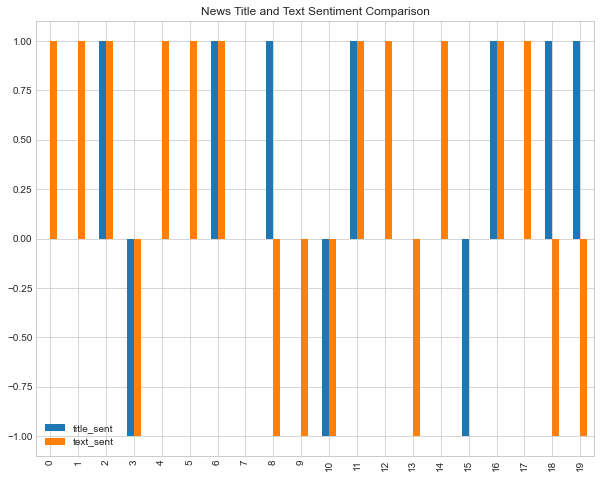

In [80]:
# Analyze Crypto Results:
crypto_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)

In [81]:
# Get Stats on Crypto Dataframe
crypto_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000
mean,0.072060,0.078450,0.887900,0.033650,0.200000,0.116105,0.081450,0.875100,0.04345,0.200000
std,0.232018,0.119523,0.120482,0.076078,0.695852,0.428887,0.054884,0.073269,0.06401,0.951453
min,-0.340000,0.000000,0.656000,0.000000,-1.000000,-0.765000,0.000000,0.729000,0.00000,-1.000000
25%,0.000000,0.000000,0.807000,0.000000,0.000000,-0.225725,0.043500,0.833250,0.00000,-1.000000
50%,0.000000,0.000000,0.892000,0.000000,0.000000,0.197700,0.077500,0.885500,0.00000,1.000000
75%,0.109025,0.189000,1.000000,0.000000,1.000000,0.447800,0.124750,0.922250,0.08750,1.000000
max,0.636900,0.344000,1.000000,0.286000,1.000000,0.680800,0.185000,1.000000,0.21600,1.000000


<AxesSubplot:title={'center':'News Title and Text Sentiment Comparison'}>

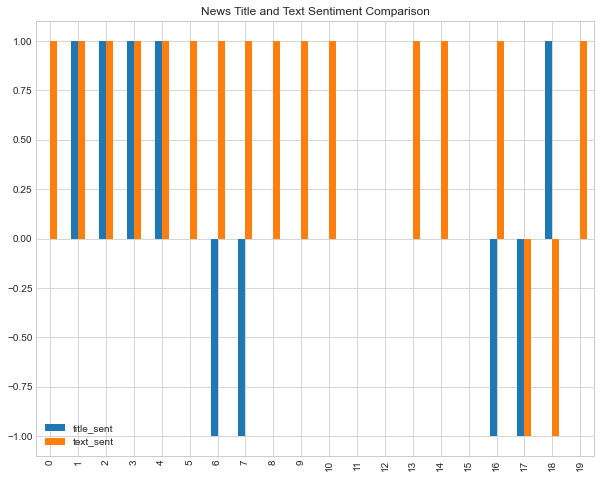

In [82]:
# Analyze Open Banking Results:
openbanking_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)

In [83]:
# Get Stats on Open Banking Dataframe
openbanking_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000
mean,0.055055,0.094450,0.854400,0.051100,0.050000,0.224480,0.084400,0.887450,0.028100,0.65000
std,0.300924,0.133068,0.164306,0.092365,0.686333,0.430340,0.074977,0.078679,0.060459,0.67082
min,-0.440400,0.000000,0.541000,0.000000,-1.000000,-0.812600,0.000000,0.732000,0.000000,-1.00000
25%,0.000000,0.000000,0.744000,0.000000,0.000000,0.057900,0.028500,0.843500,0.000000,0.75000
50%,0.000000,0.000000,0.920000,0.000000,0.000000,0.236950,0.066000,0.904000,0.000000,1.00000
75%,0.095450,0.184250,1.000000,0.040000,0.250000,0.547425,0.144250,0.939250,0.009750,1.00000
max,0.624900,0.459000,1.000000,0.244000,1.000000,0.836000,0.268000,1.000000,0.215000,1.00000


<AxesSubplot:title={'center':'News Title and Text Sentiment Comparison'}>

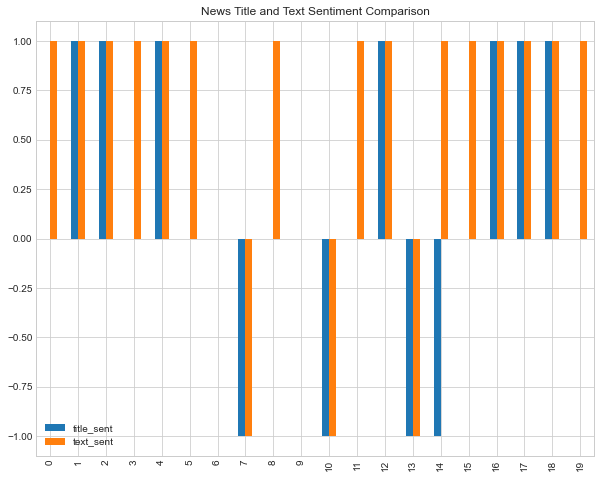

In [84]:
# Analyze Banking Results:
banking_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)

In [85]:
# Get Stats on Banking Dataframe
banking_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.000000,20.00000,20.00000,20.000000,20.000000,20.00000,20.000000,20.000000
mean,0.086860,0.129000,0.798000,0.07295,0.15000,0.355640,0.123700,0.83960,0.036750,0.600000
std,0.381627,0.185297,0.202395,0.13677,0.74516,0.432807,0.079698,0.08382,0.052773,0.753937
min,-0.612400,0.000000,0.278000,0.00000,-1.00000,-0.718400,0.000000,0.70700,0.000000,-1.000000
25%,0.000000,0.000000,0.644500,0.00000,0.00000,0.077025,0.072750,0.78300,0.000000,0.750000
50%,0.000000,0.000000,0.789000,0.00000,0.00000,0.517050,0.135500,0.83250,0.000000,1.000000
75%,0.334100,0.208500,1.000000,0.04425,1.00000,0.694375,0.169250,0.90225,0.070250,1.000000
max,0.855500,0.722000,1.000000,0.41200,1.00000,0.836000,0.268000,1.00000,0.176000,1.000000


### Sentiment Analysis Conclusions:

Q: Which concept (Cryptocurrency, Open Banking, or Banking) had the highest mean positive score?

A: 

Q: Which concept had the highest compound score?

A: 

Q. Which concept had the highest positive score?

A:


## Natural Language Processing (Cryptocurrency vs. Open Banking vs. Banking)

In [86]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [87]:
# Cryptocurrency News
article = crypto_news
print(article)

{'status': 'ok', 'totalResults': 10407, 'articles': [{'source': {'id': 'engadget', 'name': 'Engadget'}, 'author': 'Igor Bonifacic', 'title': 'Robinhood opens cryptocurrency wallet to beta testers', 'description': 'Back in September\r\n, Robinhood announced plans to test a cryptocurrency wallet within its app. At the time, the company said it would open the beta to a small number of people before expanding availability ahead of a full-scale release. If you joined the wait…', 'url': 'https://www.engadget.com/robinhood-cryptocurrency-wallet-beta-225721593.html', 'urlToImage': 'https://s.yimg.com/os/creatr-uploaded-images/2021-09/5035fef0-1bd6-11ec-b7e5-a610838e0b98', 'publishedAt': '2022-01-21T22:57:21Z', 'content': 'Back in September\r\n, Robinhood announced plans to test a cryptocurrency wallet within its app. At the time, the company said it would open the beta to a small number of people before expanding availa… [+1069 chars]'}, {'source': {'id': 'wired', 'name': 'Wired'}, 'author': '

In [88]:
# Open Banking News
article2 = openbanking_news
print(article2)

{'status': 'ok', 'totalResults': 2757, 'articles': [{'source': {'id': 'reuters', 'name': 'Reuters'}, 'author': None, 'title': 'Indian shares open lower as IT, banks weigh - Reuters India', 'description': 'Indian shares edged lower on Friday, pressured by IT and banking stocks, with investors focused on the East-West standoff over Ukraine, which has roiled markets this week.', 'url': 'https://www.reuters.com/world/india/indian-shares-open-lower-it-banks-weigh-2022-02-18/', 'urlToImage': 'https://www.reuters.com/resizer/1o3yBGdN4NLOe5wvYM1EltN1alM=/1200x628/smart/filters:quality(80)/cloudfront-us-east-2.images.arcpublishing.com/reuters/EFGMTS3Y4JPKJN7YTA3AH3IKVE.jpg', 'publishedAt': '2022-02-18T04:05:00Z', 'content': 'BENGALURU, Feb 18 (Reuters) - Indian shares edged lower on Friday, pressured by IT and banking stocks, with investors focused on the East-West standoff over Ukraine, which has roiled markets this wee… [+874 chars]'}, {'source': {'id': 'business-insider', 'name': 'Business I

In [89]:
# Banking News
article3 = banking_news
print(article3)

{'status': 'ok', 'totalResults': 13428, 'articles': [{'source': {'id': None, 'name': 'Insiderintelligence.com'}, 'author': 'insider@insider.com (Insider Intelligence)', 'title': 'The Banking CMO Report Preview', 'description': "Get an exclusive preview of the Banking CMO Report and to start receiving our Financial Services newsletter, Insider Intelligence Daily, which covers today's most important trends in banking, fintech, and payments.", 'url': 'https://www.insiderintelligence.com/resources/banking-cmo-preview-2021/', 'urlToImage': 'https://www.insiderintelligence.com/static/II_White_On_Black-855f55175b03be1ac1344daa89edbc4f.png', 'publishedAt': '2022-02-08T22:04:00Z', 'content': 'Our Banking CMO Report synthesizes interviews with 10 CMOs at some of the largest and most innovative banks, credit unions, and neobanks in the US and Canada.\r\nThrough our exclusive interviews, we pr… [+468 chars]'}, {'source': {'id': 'business-insider', 'name': 'Business Insider'}, 'author': 'sacevedo@i

In [91]:
# Complete the tokenizer function - Cryptocurrency
def tokenizer(text):
    """Tokenizes text."""
    
    # Create a list of the words
    words = word_tokenize(text)

    # Convert the words to lowercase
    words = list(filter(lambda w: w.lower(), words))
    
    # Remove the punctuation
    words = list(filter(lambda t: t not in punctuation, words))
    
    # NEED TO FIX STOPWORDS
    # Remove the stopwords 
    # words = list(filter(lambda t: t.lower() not in stop, words))
   
    # Lemmatize Words into root words
    tokens = [lemmatizer.lemmatize(word) for word in words]
    
    return tokens

# Create a new tokens column for Cryptocurrency
crypto_df["tokens"] = crypto_df.text.apply(tokenizer)
crypto_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,Robinhood opens cryptocurrency wallet to beta ...,"Back in September\r\n, Robinhood announced pla...","Back in September\r\n, Robinhood announced pla...",2022-01-21,en,0.0000,0.000,1.000,0.000,0,0.0772,0.038,0.962,0.000,1,"[Back, in, September, Robinhood, announced, pl..."
1,Gibraltar Could Launch the World’s First Crypt...,“The Rock” hopes a new stock exchange will att...,British entrepreneur and financier Richard ODe...,2022-01-26,en,0.0000,0.000,1.000,0.000,0,0.6808,0.185,0.815,0.000,1,"[British, entrepreneur, and, financier, Richar..."
2,The International Monetary Fund tells El Salva...,The International Monetary Fund’s executive di...,El Salvador introduced Bitcoin as a legal tend...,2022-01-25,en,0.1280,0.103,0.897,0.000,1,0.3182,0.105,0.895,0.000,1,"[El, Salvador, introduced, Bitcoin, a, a, lega..."
3,The DOJ's $3.6B Seizure Shows How Hard It Is t...,A couple allegedly used a “laundry list” of te...,"On Tuesday, Ilya Lichtenstein and Heather Morg...",2022-02-09,en,-0.1027,0.000,0.887,0.113,-1,-0.7650,0.048,0.736,0.216,-1,"[On, Tuesday, Ilya, Lichtenstein, and, Heather..."
4,Is the Crypto Bubble Going to Burst?,Even if you aren’t paying attention to Bitcoin...,Even if you arent paying attention to Bitcoin ...,2022-02-09,en,0.0000,0.000,1.000,0.000,0,0.5859,0.124,0.876,0.000,1,"[Even, if, you, arent, paying, attention, to, ..."


In [93]:
# Complete the tokenizer function - Open Banking
def tokenizer(text):
    """Tokenizes text."""
    
    # Create a list of the words
    words = word_tokenize(text)

    # Convert the words to lowercase
    words = list(filter(lambda w: w.lower(), words))
    
    # Remove the punctuation
    words = list(filter(lambda t: t not in punctuation, words))

    # NEED TO FIX STOPWORDS
    # Remove the stopwords
    #words = list(filter(lambda t: t.lower() not in stop, words))
    
    # Lemmatize Words into root words
    tokens = [lemmatizer.lemmatize(word) for word in words]
    
    return tokens

# Create a new tokens column for Bitcoin
openbanking_df["tokens"] = openbanking_df.text.apply(tokenizer)
openbanking_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,"Indian shares open lower as IT, banks weigh - ...","Indian shares edged lower on Friday, pressured...","BENGALURU, Feb 18 (Reuters) - Indian shares ed...",2022-02-18,en,0.0000,0.177,0.645,0.177,0,0.1779,0.127,0.765,0.108,1,"[BENGALURU, Feb, 18, Reuters, Indian, share, e..."
1,"Finicity co-founder talks open banking, fintec...",Finicity CEO Steve Smith talks about how socia...,Although the UK pioneered open-\r\nbanking reg...,2022-02-04,en,0.5106,0.292,0.708,0.000,1,0.6705,0.151,0.849,0.000,1,"[Although, the, UK, pioneered, open-, banking,..."
2,Plaid's Cognito deal helps it plan ahead for U...,Open-banking provider Plaid has acquired Cogni...,The news: The \r\nopen-banking provider Plaid ...,2022-01-21,en,0.3818,0.206,0.794,0.000,1,0.5859,0.156,0.844,0.000,1,"[The, news, The, open-banking, provider, Plaid..."
3,"Relationship banking can offer special perks, ...",Banks use relationship banking to build relati...,Relationship banking is a term you'll frequent...,2022-02-04,en,0.4939,0.208,0.792,0.000,1,0.4588,0.091,0.909,0.000,1,"[Relationship, banking, is, a, term, you, 'll,..."
4,Spruce banking review: Banking platform with c...,H&R Block has a new financial technology platf...,The bottom line:Spruce is a solid \r\nmobile b...,2022-01-21,en,0.4767,0.220,0.780,0.000,1,0.8360,0.268,0.732,0.000,1,"[The, bottom, line, Spruce, is, a, solid, mobi..."


In [94]:
# Complete the tokenizer function - Banking
def tokenizer(text):
    """Tokenizes text."""
    
    # Create a list of the words
    words = word_tokenize(text)

    # Convert the words to lowercase
    words = list(filter(lambda w: w.lower(), words))
    
    # Remove the punctuation
    words = list(filter(lambda t: t not in punctuation, words))
    
    # NEED TO FIX STOPWORDS
    # Remove the stopwords
    #words = list(filter(lambda t: t.lower() not in stop, words))
    
    # Lemmatize Words into root words
    tokens = [lemmatizer.lemmatize(word) for word in words]
    
    return tokens

# Create a new tokens column for Bitcoin
banking_df["tokens"] = banking_df.text.apply(tokenizer)
banking_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,The Banking CMO Report Preview,Get an exclusive preview of the Banking CMO Re...,Our Banking CMO Report synthesizes interviews ...,2022-02-08,en,0.0000,0.000,1.000,0.0,0,0.7620,0.191,0.809,0.000,1,"[Our, Banking, CMO, Report, synthesizes, inter..."
1,Spruce banking review: Banking platform with c...,H&R Block has a new financial technology platf...,The bottom line:Spruce is a solid \r\nmobile b...,2022-01-21,en,0.4767,0.220,0.780,0.0,1,0.8360,0.268,0.732,0.000,1,"[The, bottom, line, Spruce, is, a, solid, mobi..."
2,"India shares gain on energy, banking boost - R...","Indian shares rose on Friday, lifted by energy...","BENGALURU, Jan 28 (Reuters) - Indian shares ro...",2022-01-28,en,0.8555,0.722,0.278,0.0,1,0.7650,0.213,0.787,0.000,1,"[BENGALURU, Jan, 28, Reuters, Indian, share, r..."
3,LIVE MARKETS Banking on banks in 2022 - Reuters,Welcome to the home for real-time coverage of ...,Jan 25 - Welcome to the home for real-time cov...,2022-01-25,en,0.0000,0.000,1.000,0.0,0,0.6369,0.144,0.856,0.000,1,"[Jan, 25, Welcome, to, the, home, for, real-ti..."
4,"Australian shares weighed down by banking, hea...","Australian shares slipped on Monday, as losses...",Feb 7 (Reuters) - Australian shares slipped on...,2022-02-07,en,0.2960,0.216,0.784,0.0,1,0.6808,0.227,0.707,0.066,1,"[Feb, 7, Reuters, Australian, share, slipped, ..."


In [95]:
# Stop words
# NLTK list of stopwords
print(stopwords.words('english'))

languages = ['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek','hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']

for lang in languages:
    print("stopwords in:", lang, ":", len(stopwords.words(lang)))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [97]:
# Add Stop Words - NEED TO FIX
#sw = set(stopwords.words('english'))
#first_result = [word.lower() for word in words if word.lower() not in sw]
#sw_addon = {'id', 'none', 'name', 'reuters', 'source', 'author', 'title', 'business', 'content'}
#second_result = [word.lower() for word in words if word.lower() not in sw.union(sw_addon)]

## NGrams and Frequency Analysis

In [98]:
# Generate the Crypto N-grams where N=2
def process_text(article):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', str(crypto_news))
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in words if word.lower() not in sw]
    return output

In [99]:
processed = process_text(article)
print(processed)

['status', 'ok', 'totalresults', 'articles', 'source', 'id', 'engadget', 'name', 'engadget', 'author', 'igor', 'bonifacic', 'title', 'robinhood', 'opens', 'cryptocurrency', 'wallet', 'beta', 'testers', 'description', 'back', 'septemberrn', 'robinhood', 'announced', 'plans', 'test', 'cryptocurrency', 'wallet', 'within', 'app', 'time', 'company', 'said', 'would', 'open', 'beta', 'small', 'number', 'people', 'expanding', 'availability', 'ahead', 'fullscale', 'release', 'joined', 'wait', 'url', 'httpswwwengadgetcomrobinhoodcryptocurrencywalletbetahtml', 'urltoimage', 'httpssyimgcomoscreatruploadedimagesfefbdecbeaeb', 'publishedat', 'tz', 'content', 'back', 'septemberrn', 'robinhood', 'announced', 'plans', 'test', 'cryptocurrency', 'wallet', 'within', 'app', 'time', 'company', 'said', 'would', 'open', 'beta', 'small', 'number', 'people', 'expanding', 'availa', 'chars', 'source', 'id', 'wired', 'name', 'wired', 'author', 'gian', 'volpicelli', 'title', 'gibraltar', 'could', 'launch', 'worlds'

In [100]:
crypto_bigram_counts = Counter(ngrams(processed, n=2))
print(dict(crypto_bigram_counts))

{('status', 'ok'): 1, ('ok', 'totalresults'): 1, ('totalresults', 'articles'): 1, ('articles', 'source'): 1, ('source', 'id'): 20, ('id', 'engadget'): 2, ('engadget', 'name'): 2, ('name', 'engadget'): 2, ('engadget', 'author'): 2, ('author', 'igor'): 1, ('igor', 'bonifacic'): 1, ('bonifacic', 'title'): 1, ('title', 'robinhood'): 1, ('robinhood', 'opens'): 1, ('opens', 'cryptocurrency'): 1, ('cryptocurrency', 'wallet'): 3, ('wallet', 'beta'): 1, ('beta', 'testers'): 1, ('testers', 'description'): 1, ('description', 'back'): 1, ('back', 'septemberrn'): 2, ('septemberrn', 'robinhood'): 2, ('robinhood', 'announced'): 2, ('announced', 'plans'): 2, ('plans', 'test'): 2, ('test', 'cryptocurrency'): 2, ('wallet', 'within'): 2, ('within', 'app'): 2, ('app', 'time'): 2, ('time', 'company'): 2, ('company', 'said'): 2, ('said', 'would'): 2, ('would', 'open'): 2, ('open', 'beta'): 2, ('beta', 'small'): 2, ('small', 'number'): 2, ('number', 'people'): 2, ('people', 'expanding'): 2, ('expanding', 'av

In [101]:
# Generate the Open Banking N-grams where N=2
def process_text(article2):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', str(openbanking_news))
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in words if word.lower() not in sw]
    return output

processed2 = process_text(article2)
print(processed2)

openbanking_bigram_counts = Counter(ngrams(processed2, n=2))
print(dict(openbanking_bigram_counts))

['status', 'ok', 'totalresults', 'articles', 'source', 'id', 'reuters', 'name', 'reuters', 'author', 'none', 'title', 'indian', 'shares', 'open', 'lower', 'banks', 'weigh', 'reuters', 'india', 'description', 'indian', 'shares', 'edged', 'lower', 'friday', 'pressured', 'banking', 'stocks', 'investors', 'focused', 'eastwest', 'standoff', 'ukraine', 'roiled', 'markets', 'week', 'url', 'httpswwwreuterscomworldindiaindiansharesopenloweritbanksweigh', 'urltoimage', 'httpswwwreuterscomresizeroybgdnnloewvymeltnalmxsmartfiltersqualitycloudfrontuseastimagesarcpublishingcomreutersefgmtsyjpkjnytaahikvejpg', 'publishedat', 'tz', 'content', 'bengaluru', 'feb', 'reuters', 'indian', 'shares', 'edged', 'lower', 'friday', 'pressured', 'banking', 'stocks', 'investors', 'focused', 'eastwest', 'standoff', 'ukraine', 'roiled', 'markets', 'wee', 'chars', 'source', 'id', 'businessinsider', 'name', 'business', 'insider', 'author', 'insiderinsidercom', 'tyler', 'van', 'dyke', 'title', 'finicity', 'cofounder', '

In [102]:
# Generate the Banking N-grams where N=2
def process_text(article3):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', str(banking_news))
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in words if word.lower() not in sw]
    return output

processed3 = process_text(article3)
print(processed3)

banking_bigram_counts = Counter(ngrams(processed3, n=2))
print(dict(banking_bigram_counts))

['status', 'ok', 'totalresults', 'articles', 'source', 'id', 'none', 'name', 'insiderintelligencecom', 'author', 'insiderinsidercom', 'insider', 'intelligence', 'title', 'banking', 'cmo', 'report', 'preview', 'description', 'get', 'exclusive', 'preview', 'banking', 'cmo', 'report', 'start', 'receiving', 'financial', 'services', 'newsletter', 'insider', 'intelligence', 'daily', 'covers', 'todays', 'important', 'trends', 'banking', 'fintech', 'payments', 'url', 'httpswwwinsiderintelligencecomresourcesbankingcmopreview', 'urltoimage', 'httpswwwinsiderintelligencecomstaticiiwhiteonblackfbbeacdaaedbcfpng', 'publishedat', 'tz', 'content', 'banking', 'cmo', 'report', 'synthesizes', 'interviews', 'cmos', 'largest', 'innovative', 'banks', 'credit', 'unions', 'neobanks', 'us', 'canadarnthrough', 'exclusive', 'interviews', 'pr', 'chars', 'source', 'id', 'businessinsider', 'name', 'business', 'insider', 'author', 'sacevedoinsidercom', 'sophia', 'acevedo', 'title', 'spruce', 'banking', 'review', 'b

In [103]:
# Function token_count generates the top 10 words for a given concept
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [104]:
# Use token_count to get the top 10 words for Crypto
print(dict(crypto_bigram_counts.most_common(10)))

{('source', 'id'): 20, ('publishedat', 'tz'): 20, ('tz', 'content'): 20, ('chars', 'source'): 19, ('heather', 'morgan'): 7, ('id', 'none'): 7, ('none', 'name'): 7, ('ilya', 'lichtenstein'): 6, ('new', 'york'): 6, ('id', 'wired'): 5}


In [105]:
# Use token_count to get the top 10 words for Open Banking
print(dict(openbanking_bigram_counts.most_common(10)))

{('source', 'id'): 20, ('publishedat', 'tz'): 20, ('tz', 'content'): 20, ('chars', 'source'): 19, ('id', 'reuters'): 8, ('reuters', 'name'): 8, ('name', 'reuters'): 8, ('reuters', 'author'): 8, ('author', 'none'): 8, ('none', 'title'): 8}


In [106]:
# Use token_count to get the top 10 words for Banking
print(dict(banking_bigram_counts.most_common(10)))

{('source', 'id'): 20, ('publishedat', 'tz'): 20, ('tz', 'content'): 20, ('chars', 'source'): 19, ('id', 'reuters'): 11, ('reuters', 'name'): 11, ('name', 'reuters'): 11, ('reuters', 'author'): 11, ('author', 'none'): 11, ('none', 'title'): 11}


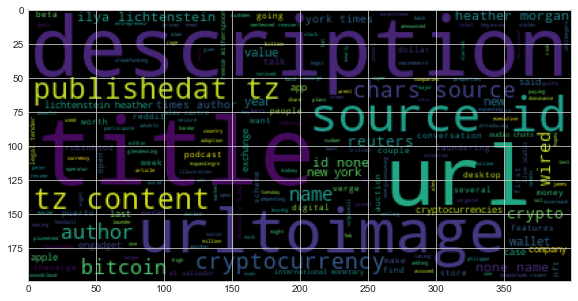

In [107]:
# Generate the Crypto word cloud
wc = WordCloud().generate(' '.join(processed))
plt.imshow(wc)

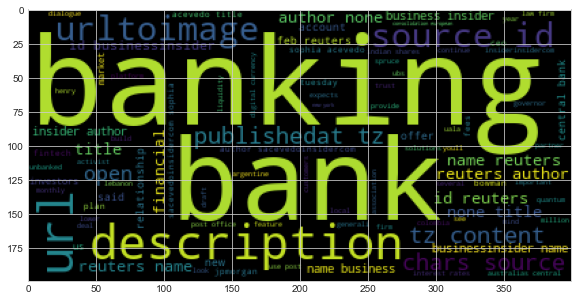

In [108]:
# Generate the Crypto word cloud
wc = WordCloud().generate(' '.join(processed2))
plt.imshow(wc)

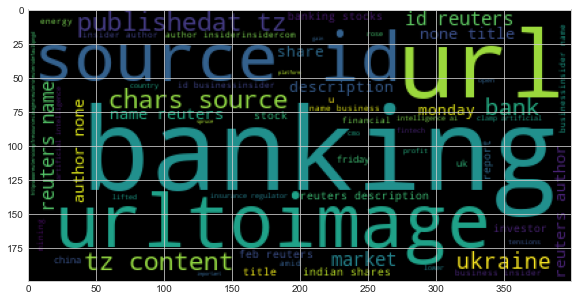

In [53]:
# Generate the Crypto word cloud
wc = WordCloud().generate(' '.join(processed3))
plt.imshow(wc)